# CARLINI WAGNER #

Ricordati di cambiare le cartelle del test set.

#### *Import* 

In [3]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod
from RESNET import ResNet
from utils import get_labels
from utils import load_state_dict
from utils import load_image_NN1
from utils import load_test_image_NN2
from utils import load_test_image_NN2_preprocessed
from utils import load_image_NN2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)
print(device)

cuda


In [4]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    nn1 = inception.InceptionResnetV1(pretrained='vggface2').eval()
    device_classifier = "gpu"
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import Inceptionnn1V1
    nn1 = InceptionResnetV1(pretrained='vggface2').eval()
    device_classifier = "cpu"

Import Inception.Inception


#### Inizializzazione

In [5]:
# ----------------------------nn1-----------------------
nn1.classify = True
nn1.to(device)
fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
model_nn1 = PyTorchClassifier(nn1,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device_classifier) #This class implements a classifier with the PyTorch framework.

# ---------------------nn2-----------------------------
nn2 = ResNet.resnet50(num_classes=8631, include_top=True)
load_state_dict(nn2,'resnet50_scratch_weight.pkl')
nn2.eval()
nn2.to(device)
model_nn2 = PyTorchClassifier(nn2,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type="gpu")

#--------------------------------------------------------
LABELS = get_labels()

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    tns.to(device)
    return tns


#### SIGNIFICATO PARAMETRI 


Il metodo Carlini and Wagner L_0 Attack è un attacco iterativo che mira a trovare un esempio avversario minimizzando il numero di caratteristiche modificate (norma L_0). Ecco una spiegazione dettagliata del metodo e dei suoi parametri:

Metodo Carlini and Wagner L_0 Attack
Parametri del Metodo __init__

classifier (CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE):
Un classificatore addestrato che implementa i metodi per calcolare le perdite e i gradienti delle perdite rispetto agli input.

confidence (float = 0.0):
La fiducia degli esempi avversari: un valore più alto produce esempi che sono più lontani dall'input originale ma classificati con maggiore fiducia come la classe target. Questo parametro bilancia la necessità di modificare l'input originale con la certezza che l'output sia nella classe avversaria desiderata.

targeted (bool = False):
Indica se l'attacco è mirato a una specifica classe (True) o meno (False). In un attacco mirato, l'obiettivo è far classificare l'input avversario come una classe specifica scelta dall'attaccante. In un attacco non mirato, l'obiettivo è semplicemente far classificare l'input in una classe diversa da quella corretta.

learning_rate (float = 0.01):
Il tasso di apprendimento iniziale per l'algoritmo di attacco. Valori più piccoli producono risultati migliori ma convergono più lentamente.

binary_search_steps (int = 10):
Numero di volte in cui regolare la costante con la ricerca binaria (valore positivo). Se binary_search_steps è grande, l'algoritmo non è molto sensibile al valore di initial_const. Questo parametro controlla quante volte la costante di trade-off viene aggiustata per trovare il miglior equilibrio tra la distanza e la fiducia.

max_iter (int = 10):
Il numero massimo di iterazioni per l'attacco.

initial_const (float = 0.01):
La costante di trade-off iniziale c per regolare l'importanza relativa tra la distanza e la fiducia. Se binary_search_steps è grande, il valore iniziale di questa costante non è critico.

mask (ndarray | None = None):
Le caratteristiche iniziali che possono essere modificate dall'algoritmo. Se non specificato, l'algoritmo utilszza l'intero set di caratteristiche. Questo parametro può essere utilszzato per limitare l'attacco a modificare solo determinate parti dell'input.

warm_start (bool = True):
Invece di iniziare la discesa del gradiente in ogni iterazione dall'immagine iniziale, si inizia la discesa del gradiente dalla soluzione trovata nell'iterazione precedente. Questo parametro può accelerare la convergenza.

max_halving (int = 5):
Numero massimo di passi di dimezzamento nella ricerca lineare di ottimizzazione. Questo parametro controlla quante volte la dimensione del passo viene dimezzata durante la ricerca di un passo ottimale.

max_doubling (int = 5):
Numero massimo di passi di raddoppiamento nella ricerca lineare di ottimizzazione. Questo parametro controlla quante volte la dimensione del passo viene raddoppiata durante la ricerca di un passo ottimale.
batch_size (int = 1):

La dimensione del batch su cui vengono generati i campioni avversari. Questo parametro determina quanti campioni vengono processati contemporaneamente durante l'attacco.

verbose (bool = True):
Mostra barre di avanzamento. Se impostato su True, verranno visualizzati i progressi dell'attacco durante l'esecuzione.

#### *Attacco* **NON TARGETED**

In [76]:
dataset_dir = "test_set_cropped" 
binary_search_steps = 3
confidence = 0.4
max_iter = [3,16]   #a 0.01 dovrebbero uscire immagini perturbate visibilmente bene per iter=20
learning_rate = [0.0000001,0.00001,0.003,0.01,0.03,0.1,0.4] 
initial_const = [500]


correct_predictions_nn1 = 0
accuracy_for_learning_rate_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))        #riga
perturbation_for_learning_rate_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

correct_predictions_nn2 = 0
accuracy_for_learning_rate_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))       #riga


correct_predictions_nn2_preprocessed = 0
accuracy_for_learning_rate_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))


total_images = 0
print("Inizio Attacco CARLINI-WAGNER NON-TARGETED")

for z in range(len(max_iter)):
    for i in range(len(initial_const)):
            for j in range(len(learning_rate)):   
                correct_predictions_nn1 = 0
                correct_predictions_nn2 = 0
                correct_predictions_nn2_preprocessed = 0
                total_images = 0
                perturbation = []
                attack = CarliniL2Method(classifier=model_nn1, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter[z], learning_rate=learning_rate[j], initial_const=initial_const[i], targeted=False)
                
                print("<---> Attacco con learning rate = {} e max_iter = {} <--->".format(learning_rate[j],max_iter[z]))
                for filename in os.listdir(dataset_dir):
                    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                        person_path = os.path.join(dataset_dir, filename)
                        test_img = load_image_NN1(person_path,device)
                        test_img = test_img.numpy()
                        
                        test_images_adv = attack.generate(test_img)
                        #nn1_predictions = model_nn1.predict(test_images_adv)

                        differenza = test_images_adv - test_img
                        perturbation.append(np.linalg.norm(differenza)) #Salvo le perturbazioni applicate su ogni immagine

                        differenza2 = load_test_image_NN2(test_images_adv) - load_image_NN2(test_img)
                        perturbationNN2.append(np.linalg.norm(differenza2))

                        differenza3 = load_test_image_NN2_preprocessed(test_images_adv) - load_image_NN2(test_img)
                        perturbationNN2prep.append(np.linalg.norm(differenza3))
                        test_images_NN2 = load_test_image_NN2(test_images_adv)
                        nn2_predictions = model_nn2.predict(test_images_NN2)

                        test_images_NN2_preprocessed = load_test_image_NN2_preprocessed(test_images_adv)
                        nn2_predictions_preprocessed = model_nn2.predict(test_images_NN2_preprocessed)
                        

                        correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                          
                        
                
                        predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                        predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                        predicted_label_nn2_preprocessed = LABELS[np.array(nn2_predictions_preprocessed.argmax())]
                        #print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                        total_images+=1
                        
                        predicted_label_nn1 = str(predicted_label_nn1)  # da togliere ?
                        predicted_label_nn2 = str(predicted_label_nn2)
                        predicted_label_nn2_preprocessed = str(predicted_label_nn2_preprocessed)

                        if correct_label in predicted_label_nn1:
                             correct_predictions_nn1+=1

                        # #print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
                        # accuracy_nn1 = correct_predictions_nn1/total_images

                        if correct_label in predicted_label_nn2:
                            correct_predictions_nn2+=1

                        # accuracy_nn2 = correct_predictions_nn2/total_images

                        if correct_label in predicted_label_nn2_preprocessed:
                            correct_predictions_nn2_preprocessed+=1

                        # accuracy_nn2_preprocessed = correct_predictions_nn2_preprocessed/total_images


                        if total_images == 500:
                             print("\n Sei a 500 Immagini initial_cost:{} | learning_rate:{} \n".format(initial_const[i], learning_rate[i]))

                if total_images != 0:    
                    if len(perturbation) == total_images:
                        perturbazione_media = sum(perturbation)/total_images   # In media quanta pertubazione è stata applicata su ogni immagine 
                        perturbation_for_learning_rate_nn1[z][i][j] = perturbazione_media 
                        #print("----------- Perturbazione media aggiunta a tutte le immagini ---> {}% ----------------".format(learning,perturbazione_media))
                        
                        
                    final_accuracy_nn1 = correct_predictions_nn1/total_images          # Accuracy su tutte le immagini
                    accuracy_for_learning_rate_nn1[z][i][j] = final_accuracy_nn1
                    # #print("----------- Accuracy sugli adversarial Sample equivale a ---> {}% ----------------".format(learning,final_accuracy))
                    final_accuracy_nn2 = correct_predictions_nn2/total_images
                    accuracy_for_learning_rate_nn2[z][i][j] = final_accuracy_nn2

                    final_accuracy_nn2_preprocessed = correct_predictions_nn2_preprocessed/total_images
                    accuracy_for_learning_rate_nn2_preprocessed[z][i][j] = final_accuracy_nn2_preprocessed


                else:
                    print("ERRORE TOTAL IMAGE == 0 ERRORE")
                    
            print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------lllllllllllllllllll")
            print("")

Inizio Attacco CARLINI-WAGNER NON-TARGETED
<---> Attacco con learning rate = 1e-07 e max_iter = 3 <--->


C&W L_2: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]



 Sei a 500 Immagini initial_cost:500 | learning_rate:1e-07 



C&W L_2: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


<---> Attacco con learning rate = 1e-05 e max_iter = 3 <--->


C&W L_2: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]



 Sei a 500 Immagini initial_cost:500 | learning_rate:1e-07 



C&W L_2: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


<---> Attacco con learning rate = 0.003 e max_iter = 3 <--->


C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]



 Sei a 500 Immagini initial_cost:500 | learning_rate:1e-07 



C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


<---> Attacco con learning rate = 0.01 e max_iter = 3 <--->


C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]



 Sei a 500 Immagini initial_cost:500 | learning_rate:1e-07 



C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


<---> Attacco con learning rate = 0.03 e max_iter = 3 <--->


C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]



 Sei a 500 Immagini initial_cost:500 | learning_rate:1e-07 



C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


<---> Attacco con learning rate = 0.1 e max_iter = 3 <--->


C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]



 Sei a 500 Immagini initial_cost:500 | learning_rate:1e-07 



C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


<---> Attacco con learning rate = 0.4 e max_iter = 3 <--->


C&W L_2: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]



 Sei a 500 Immagini initial_cost:500 | learning_rate:1e-07 



C&W L_2: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------lllllllllllllllllll



In [6]:
print(learning_rate)
print(accuracy_for_learning_rate_nn1)
print(accuracy_for_learning_rate_nn2)
print(accuracy_for_learning_rate_nn2_preprocessed)

[1e-07, 1e-05, 0.003, 0.01, 0.03, 0.1, 0.4]
[[[0.082 0.043 0.043 0.038 0.035 0.031 0.03 ]]

 [[0.043 0.043 0.043 0.038 0.035 0.031 0.03 ]]]
[[[0.882 0.883 0.848 0.681 0.355 0.152 0.123]]

 [[0.884 0.883 0.848 0.681 0.355 0.15  0.115]]]
[[[0.912 0.916 0.9   0.79  0.44  0.16  0.128]]

 [[0.914 0.916 0.9   0.79  0.44  0.159 0.124]]]


In [ ]:
accuracy_for_learning_rate_nn1 = [0.043, 0.043 ,0.043, 0.038, 0.035, 0.031, 0.03]
perturbation_for_learning_rate_nn1 = [ 0.5763,      0.54779171,  1.02882022,  2.22353468,  5.92853722,
   12.4773492,  13.91960094]

#### Grafico Accuracy/Perturbazione media NN1



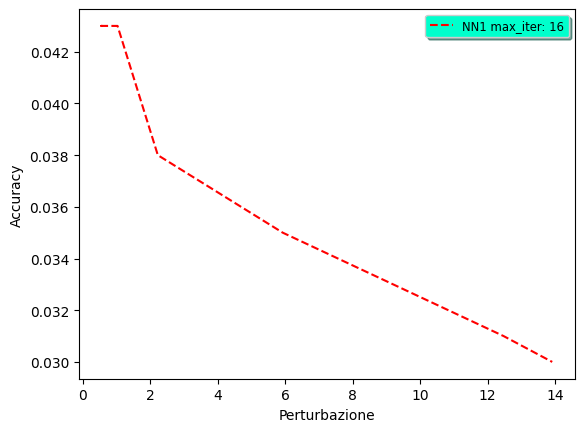

In [5]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
#ax.plot(np.array(perturbation_for_learning_rate_nn1[0][0]), np.array(accuracy_for_learning_rate_nn1[0][0]), 'b--', label='NN1 max_iter: 3')
ax.plot(perturbation_for_learning_rate_nn1[1][0], accuracy_for_learning_rate_nn1[1][0], 'r--', label='NN1 max_iter: 16')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel("Perturbazione")
plt.show()

#### Grafico NN1

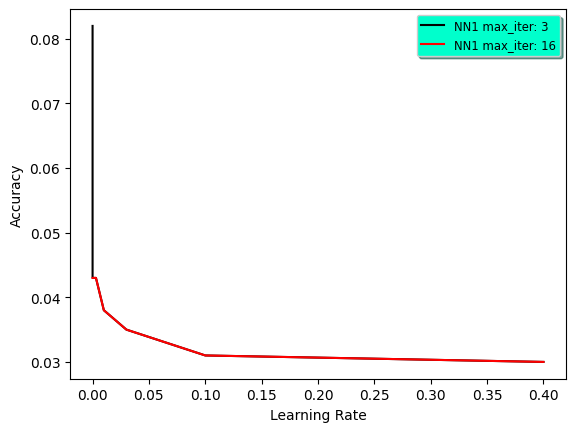

In [25]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[0][0]), 'black', label='NN1 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[1][0]), 'red', label='NN1 max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Grafico NN2

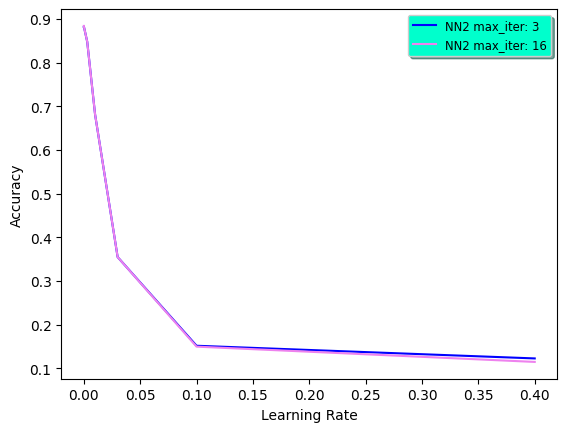

In [14]:

fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[0][0]), 'blue', label='NN2 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[1][0]), 'violet', label='NN2 max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Grafico NN1 + NN2

Text(0.5, 0, 'Learning Rate')

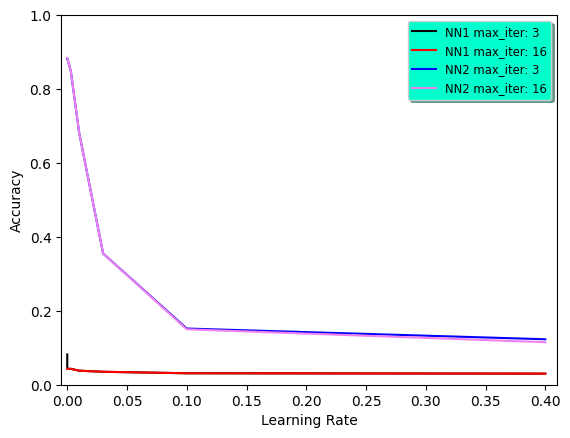

In [42]:
fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[0][0]), 'black', label='NN1 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[1][0]), 'red', label='NN1 max_iter: 16')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[0][0]), 'blue', label='NN2 max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[1][0]), 'violet', label='NN2 max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
ax.set_xlim(learning_rate[0]-0.005, learning_rate[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

#### NN2 Preprocessed

Text(0.5, 0, 'Learning Rate')

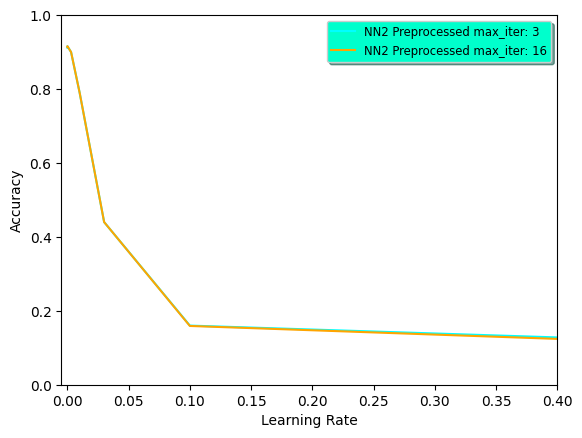

In [37]:
fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2_preprocessed[0][0]), 'cyan', label='NN2 Preprocessed max_iter: 3')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2_preprocessed[1][0]), 'orange', label='NN2 Preprocessed max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
ax.set_xlim(learning_rate[0]-0.005, learning_rate[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

#### Confronto NN1 + NN2 + NN2 Preprocessed

Text(0.5, 0, 'Learning Rate')

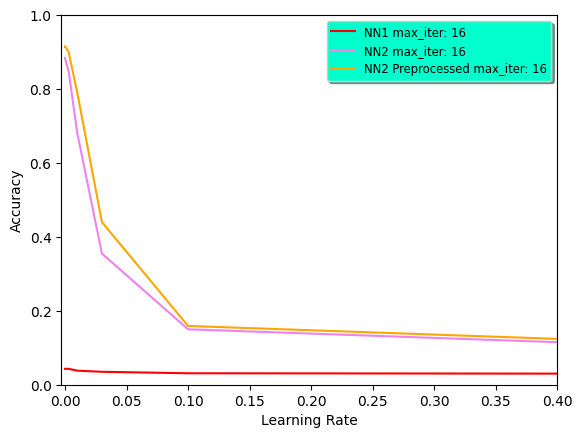

In [29]:
fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn1[1][0]), 'red', label='NN1 max_iter: 16')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2[1][0]), 'violet', label='NN2 max_iter: 16')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate_nn2_preprocessed[1][0]), 'orange', label='NN2 Preprocessed max_iter: 16')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
ax.set_xlim(learning_rate[0]-0.003, learning_rate[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

#### Singola immagine untargeted

In [43]:

from PIL import Image, ImageOps
from PIL import ImageFilter
def transform(img):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float32)
        img = img.transpose(2, 0, 1)  # C x H x W
        img = torch.from_numpy(img).float()
        return img

def load_test_image_NN2_preprocessed(test_images_adv):
    # Prepara le immagini per la visualizzazione
    # Rimuovi la dimensione batch extra e converti nel formato channels-last
    test_images_adv = np.squeeze(test_images_adv, axis=0)
    test_images_adv = np.transpose(test_images_adv, (1, 2, 0))
    if test_images_adv.dtype != np.uint8:
        test_images_adv = (test_images_adv * 255).astype(np.uint8)


    # Carica l'immagine
    img = Image.fromarray(test_images_adv)
    img = img.filter(ImageFilter.GaussianBlur(0.5))
    img = img.resize((224,224))
    # Converti l'immagine in un array NumPy
    img = np.array(img)

    # Applica le trasformazioni
    test_images_NN2 = transform(img)
    test_images_NN2 = test_images_NN2.unsqueeze(0)  # Aggiungi una dimensione batch
    return test_images_NN2

In [35]:
filename = "Brad_Pitt_1_face_0.jpg"
dataset_dir = "test_set_cropped/"

binary_search_steps = 3
confidence = 0.4
max_iter = 16
learning_rate = 0.03
initial_const = 500

attack = CarliniL2Method(classifier=model_nn1, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=False)
person_path = os.path.join(dataset_dir, filename)
test_img1 = load_image_NN1(person_path,device)
test_img = test_img1.numpy()
                        
test_images_adv = attack.generate(test_img)
print(test_images_adv.shape)
print(type(test_images_adv))
nn1_predictions = model_nn1.predict(test_images_adv)
predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]

test_images_NN2 = load_test_image_NN2(test_images_adv)
nn2_predictions = model_nn2.predict(test_images_NN2)
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]

test_images_NN2_preprocessed = load_test_image_NN2_preprocessed(test_images_adv)
nn2_predictions_preprocessed = model_nn2.predict(test_images_NN2_preprocessed)
predicted_label_nn2_preprocessed = LABELS[np.array(nn2_predictions_preprocessed.argmax())]




correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)

C&W L_2: 100%|██████████| 1/1 [00:17<00:00, 17.94s/it]

(1, 3, 160, 160)
<class 'numpy.ndarray'>


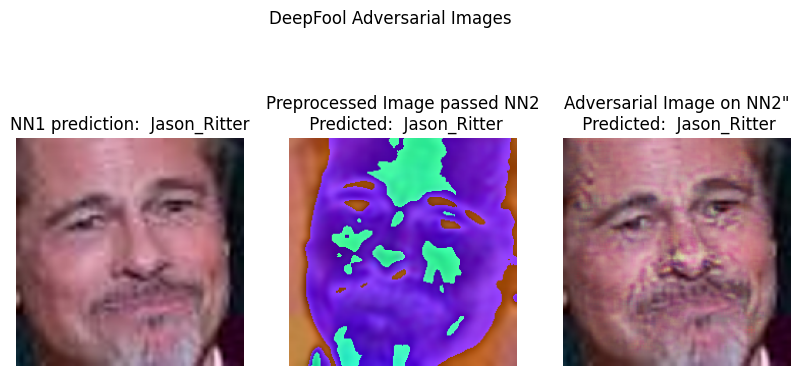

In [36]:
import cv2

test_images_NN2_preprocessed2 = np.array(test_images_NN2_preprocessed)
test_images_NN2_preprocessed2 = np.squeeze(test_images_NN2_preprocessed2, axis=0)
test_images_NN2_preprocessed2 = np.transpose(test_images_NN2_preprocessed2, (1, 2, 0))

test_images_adversarial = np.squeeze(test_images_adv, axis=0)
test_images_adversarial = np.transpose(test_images_adversarial, (1, 2, 0))
# Converti le immagini in uint8 per la visualizzazione
if test_img.dtype != np.uint8:
    test_img_numpy = (test_img * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_NN2_preprocessed2.dtype != np.uint8:
    test_images_NN2_preprocessed2 = (test_images_NN2_preprocessed2 * 255).astype(np.uint8)

if test_images_adversarial.dtype != np.uint8:
    test_images_adversarial = (test_images_adversarial * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib




fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title(f'NN1 prediction: {predicted_label_nn1}')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_NN2_preprocessed2)
ax2.set_title(f'Preprocessed Image passed NN2\n Predicted: {predicted_label_nn2_preprocessed}')
ax2.axis('off')

ax3.imshow(test_images_adversarial)
ax3.set_title(f'Adversarial Image on NN2"\n Predicted: {predicted_label_nn2}')
ax3.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()

### *Attacco* **TARGETED**

In [ ]:
dataset_dir = "test_set_cropped/" 
binary_search_steps = 2
confidence = 0.5
max_iter = [15]
learning_rate = [1e-11,1e-10,1e-09,0.0000001,0.00001,0.003,0.01,0.1,1]
initial_const = [75]

correct_predictions_nn1 = 0
correct_misclassified_nn1 = 0
accuracy_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))        #riga-colonna
perturbation_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))
accuracy_misclassified_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

correct_predictions_nn2 = 0
correct_misclassified_nn2 = 0
accuracy_for_learning_rate_targeted_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))        #riga
accuracy_misclassified_for_learning_rate_targeted_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))


correct_predictions_nn2_preprocessed = 0
correct_misclassified_nn2_preprocessed = 0
accuracy_for_learning_rate_targeted_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))
accuracy_misclassified_for_learning_rate_targeted_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

target_class = 10
etichetta_target = LABELS[target_class]
print("ETICHETTA TARGET: ", etichetta_target)

targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)


print("Inizio Attacco CARLINI-WAGNER TARGETED")
for z in range(len(max_iter)):
    for i in range(len(initial_const)):
            for j in range(len(learning_rate)):   
                correct_predictions_nn1 = 0
                correct_predictions_nn2 = 0
                correct_predictions_nn2_preprocessed = 0
                correct_misclassified_nn1 = 0
                correct_misclassified_nn2 = 0
                correct_misclassified_nn2_preprocessed = 0
                total_images = 0
                perturbation = []
                
                attack = CarliniL2Method(classifier=model_nn1,
                                          binary_search_steps=binary_search_steps,
                                            confidence=confidence, max_iter=max_iter[z],
                                              learning_rate=learning_rate[j],
                                                initial_const=initial_const[i],
                                                  targeted=True)
                
                print("<---> Attacco con max_iter = {}| learning rate = {} | initial cost = {} <--->".format(max_iter[z],learning_rate[j],initial_const[i]))
                for filename in os.listdir(dataset_dir):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image_NN1(person_path,device)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img,one_hot_targeted_labels)
                    
                    nn1_predictions = model_nn1.predict(test_images_adv,verbose = False)
                    differenza = test_images_adv - test_img
                    perturbation.append(np.linalg.norm(differenza))
                    test_images_NN2 = load_test_image_NN2(test_images_adv)
                    nn2_predictions = model_nn2.predict(test_images_NN2)

                    test_images_NN2_preprocessed = load_test_image_NN2_preprocessed(test_images_adv)
                    nn2_predictions_preprocessed = model_nn2.predict(test_images_NN2_preprocessed)

                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)  
                      #Salvo le perturbazioni applicate su ogni immagine
            
                    predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                    predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                    predicted_label_nn2_preprocessed = LABELS[np.array(nn2_predictions_preprocessed.argmax())]
                    print("Etichetta Corretta: {} | Predetto: {}  probabilità {} perturbazione applicata {} | Predetto NN2: {} | Predetto NN2PREP: {}".format(correct_label,predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()],perturbation[-1],predicted_label_nn2,predicted_label_nn2_preprocessed))
                    total_images+=1
                    
                    predicted_label_nn1 = str(predicted_label_nn1)  # da togliere ?
                    predicted_label_nn2 = str(predicted_label_nn2)
                    predicted_label_nn2_preprocessed = str(predicted_label_nn2_preprocessed)
                    
                    if correct_label in predicted_label_nn1:
                        correct_predictions_nn1 += 1
                    
                    if correct_label in predicted_label_nn2:
                        correct_predictions_nn2 += 1

                    if correct_label in predicted_label_nn2_preprocessed:
                        correct_predictions_nn2_preprocessed += 1

                    #print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
                    #accuracy_nn1 = correct_predictions_nn1/total_images

                    #---------------------MISCLASSIFIED------------------------------------------

                    if  predicted_label_nn1 in etichetta_target:  
                        correct_misclassified_nn1 += 1   #Se il modello predice l'etichetta target allora è correttamente misclassificato

                    if  predicted_label_nn2 in etichetta_target:   #se Attacco su NN2 Correttamente riuscito
                        correct_misclassified_nn2 += 1 

                    if  predicted_label_nn2_preprocessed in etichetta_target:    #se Attacco su NN2 Correttamente riuscito
                        correct_misclassified_nn2_preprocessed += 1   

                    
                    #print("Adversarial Sample misclassificati correttamente attualmente: {}%".format((accuracy_misclassified)))
                    #print("Accuracy attuale: {}%".format((correct_predictions/total_images)*100))
                
                    if total_images == 500:
                        print("Sei a 500 Immagini initial_cost:{} | learning_rate:{}".format(initial_const[i], learning_rate[j]))

                if total_images != 0:
                    # NN1    
                    if len(perturbation) == total_images:
                        # In media quanta pertubazione è stata applicata su ogni immagine
                        perturbation_for_learning_rate_targeted_nn1[z][i][j] = (sum(perturbation)/total_images)
                            
                    final_accuracy_nn1 = correct_predictions_nn1/total_images          # Accuracy su tutte le immagini
                    accuracy_for_learning_rate_targeted_nn1[z][i][j] = final_accuracy_nn1

                    final_accuracy_misclassified_nn1 = correct_misclassified_nn1/total_images
                    accuracy_misclassified_for_learning_rate_targeted_nn1[z][i][j] = final_accuracy_misclassified_nn1

                    #nn2
                    final_accuracy_nn2 = correct_predictions_nn2/total_images
                    accuracy_for_learning_rate_targeted_nn2[z][i][j] = final_accuracy_nn2

                    final_accuracy_misclassified_nn2 = correct_misclassified_nn2/total_images
                    accuracy_misclassified_for_learning_rate_targeted_nn2[z][i][j] = final_accuracy_misclassified_nn2
                    
                    #PREPROCESSED
                    final_accuracy_nn2_preprocessed = correct_predictions_nn2_preprocessed/total_images
                    accuracy_for_learning_rate_targeted_nn2_preprocessed[z][i][j] = final_accuracy_nn2_preprocessed

                    final_accuracy_misclassified_nn2_preprocessed = correct_misclassified_nn2_preprocessed/total_images
                    accuracy_misclassified_for_learning_rate_targeted_nn2_preprocessed[z][i][j] = final_accuracy_misclassified_nn2_preprocessed

                    #print("----------- Accuracy sugli adversarial Sample equivale a ---> {}% ----------------".format(learning,final_accuracy))
                else:
                    print("ERRORE TOTAL IMAGE == 0 ERRORE")
        
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("")
    
                

In [16]:
accuracy_nn1 = [0.805,0.633,0.179, 0.012, 0.01,  0.011, 0.005 ,0.001  ,0.001]
misclassified_NN1 = [0.017,0.235,0.782, 0.977, 0.982, 0.988, 0.993, 0.998, 0.999]

accuracy_nn2 = [0.875,0.809,0.651,0.691, 0.644, 0.605,0.597,0.457,0.341]
misclassified_NN2 = [0.,0.001,0.,0.,    0.,    0.002, 0., 0.01, 0.018]

accuracy_prep = [0.913,0.861,0.75,0.804, 0.785, 0.722, 0.728, 0.56, 0.396]
misclassified_PREP = [0,0.001,0, 0.,    0.,    0.002, 0., 0.028, 0.051]


perturbazione = [0.09596873,1.23081574,4.07455965,4.3993285,  4.63678103, 5.40713831,]

#### Grafico accuracy/perturbazione NN1

NameError: name 'perturbation_for_learning_rate_nn1' is not defined

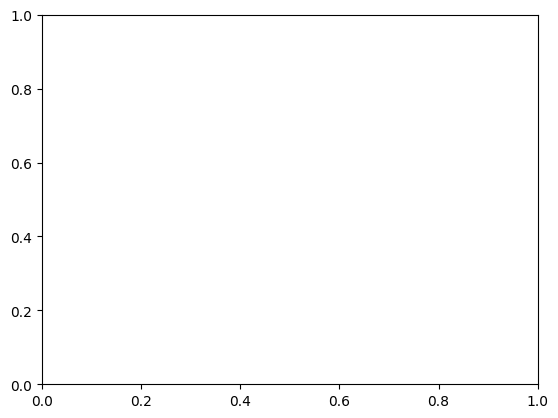

In [40]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
#ax.plot(np.array(perturbation_for_learning_rate_nn1[0][0]), np.array(accuracy_for_learning_rate_nn1[0][0]), 'b--', label='NN1 max_iter: 3')
ax.plot(perturbation_for_learning_rate_nn1[1][0], accuracy_for_learning_rate_nn1[1][0], 'r--', label='NN1 max_iter: 16')

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel("Perturbazione")
plt.show()

#### Grafico NN1

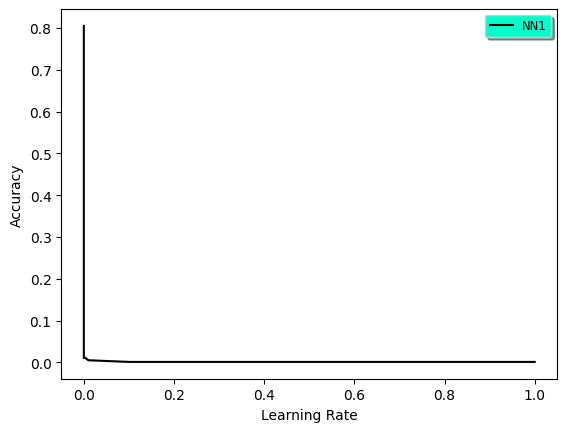

In [41]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_nn1, 'black', label='NN1')



legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### MISCLASSIFIED NN1

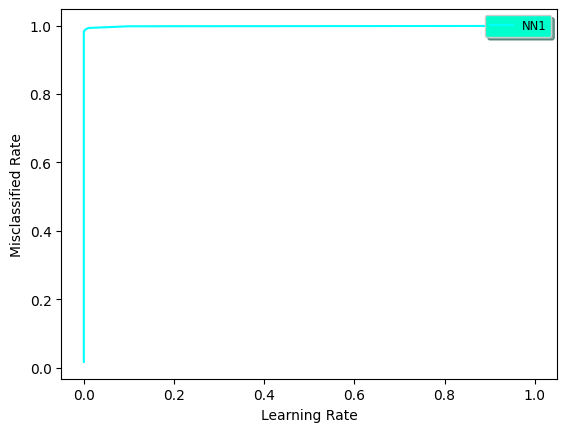

In [42]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, misclassified_NN1, 'cyan', label='NN1')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Misclassified Rate')
plt.xlabel('Learning Rate')


plt.show()

#### Accuracy NN2 

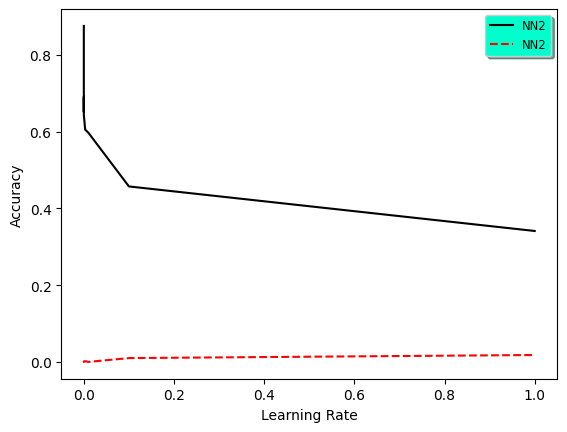

In [38]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_nn2, 'black', label='NN2')
ax.plot(learning_rate, misclassified_NN2, '--r', label='NN2')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Misclassified NN2

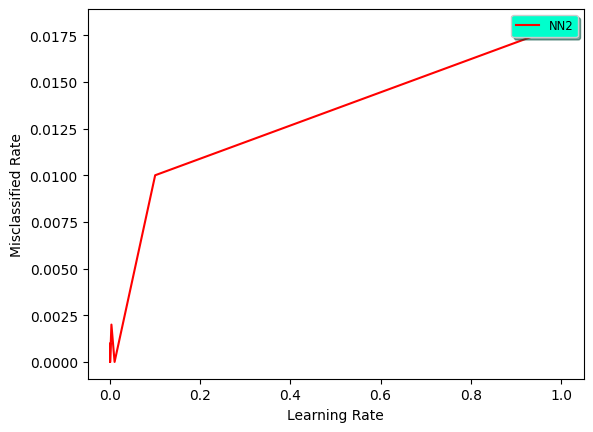

In [37]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()

ax.plot(learning_rate, misclassified_NN2, 'r', label='NN2')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Misclassified Rate')
plt.xlabel('Learning Rate')


plt.show()

#### Confronto NN2 e NN1

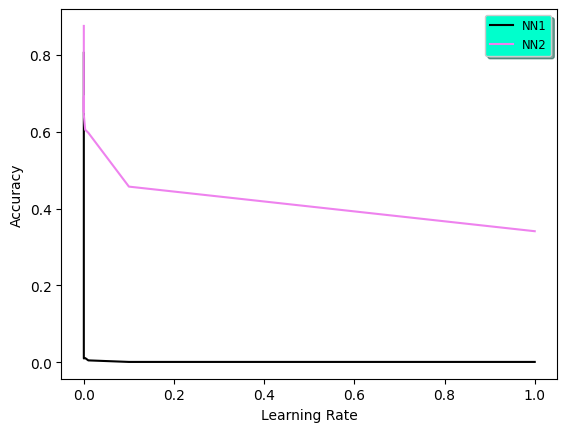

In [27]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_nn1, 'black', label='NN1')
ax.plot(learning_rate, accuracy_nn2, 'violet', label='NN2')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Accuracy Preprocessed

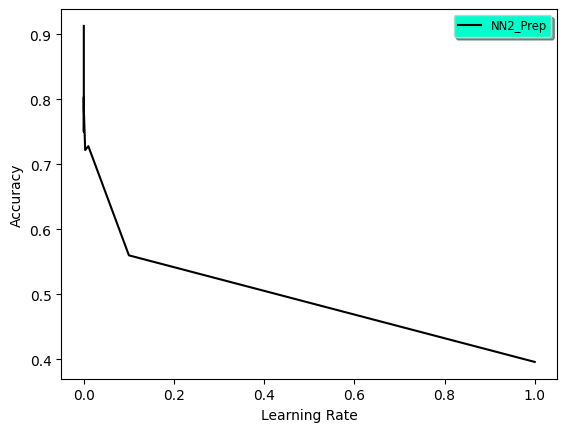

In [29]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_prep, 'black', label='NN2_Prep')



legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Confronto misclassified NN2 e NN2prep

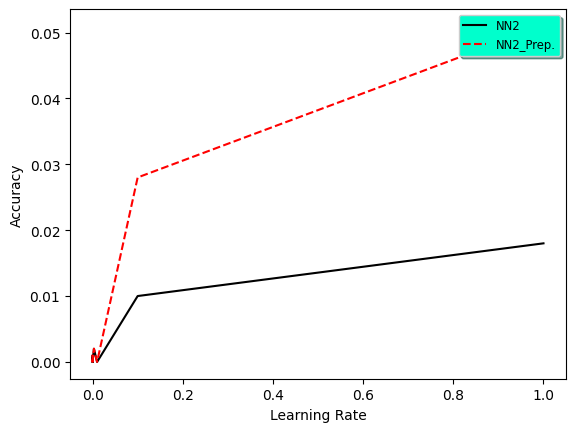

In [35]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, misclassified_NN2, 'black', label='NN2')
ax.plot(learning_rate, misclassified_PREP, '--r', label='NN2_Prep.')



legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Misclassified Rate')
plt.xlabel('Learning Rate')


plt.show()

#### Confronto NN1 NN2 NN2Prep

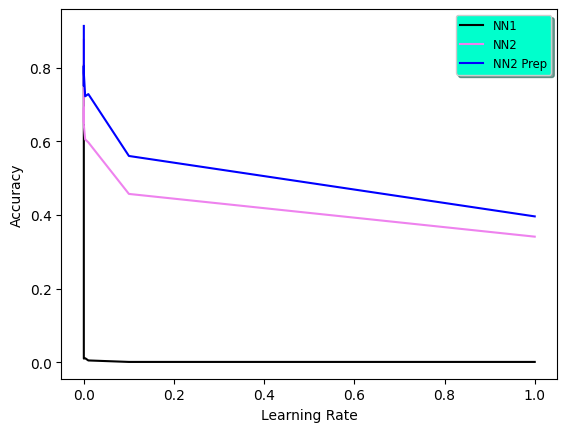

In [39]:
# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, accuracy_nn1, 'black', label='NN1')
ax.plot(learning_rate, accuracy_nn2, 'violet', label='NN2')
ax.plot(learning_rate, accuracy_prep, 'blue', label='NN2 Prep')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Caricamento di una sola immagine per i test

In [ ]:
filename = "test_set_cropped/Brad_Pitt_1_face_0.jpg"
test_img = load_image(filename)

print(test_img.shape)
print(test_img.size)
test_img = test_img.unsqueeze(0)
print(test_img.shape)
print(test_img.size)
test_img = test_img.numpy()
print(test_img.shape)
print(type(test_img))

In [ ]:
binary_search_steps = 5
confidence = 0.7
max_iter = 7
learning_rate = 0.001
initial_const = 350

target_class = 100
etichetta_target = LABELS[target_class]
print("ETICHETTA TARGET: ", etichetta_target)

targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)

attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=True)
test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
model_predictions = classifier.predict(test_images_adv)
correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)   
perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  
predicted_label = LABELS[np.array(model_predictions[0].argmax())]
print("Etichetta reale:{} || Predetto: {} con probabilità: {} e con perturbazione: {}".format(correct_label,predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    

In [8]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last

test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img.dtype != np.uint8:
    test_img_numpy = (test_img * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib


NameError: name 'predicted_label' is not defined

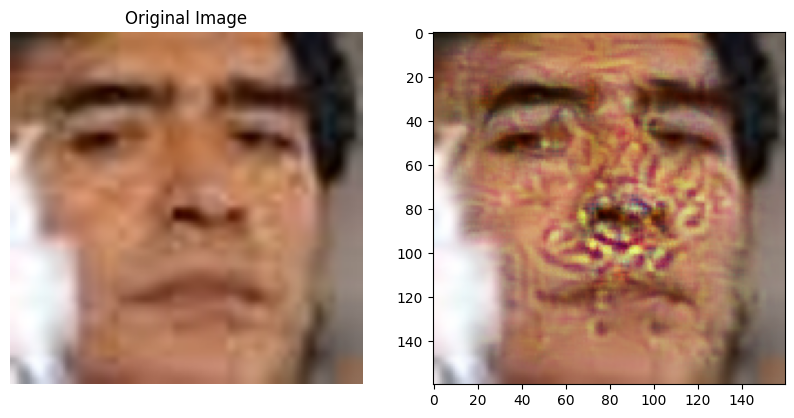

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()

# PER BEA

In [12]:
dataset_dir = "test_set_cropped/" 
binary_search_steps = 2
confidence = 0.5
max_iter = [15]
learning_rate = [1e-11,1e-10,1e-09,0.0000001,0.00001,0.003,0.01,0.1,1]
initial_const = [75]

correct_predictions_nn1 = 0
correct_misclassified_nn1 = 0
accuracy_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))        #riga-colonna
perturbation_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))
accuracy_misclassified_for_learning_rate_targeted_nn1 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

correct_predictions_nn2 = 0
correct_misclassified_nn2 = 0
accuracy_for_learning_rate_targeted_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))        #riga
accuracy_misclassified_for_learning_rate_targeted_nn2 = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))


correct_predictions_nn2_preprocessed = 0
correct_misclassified_nn2_preprocessed = 0
accuracy_for_learning_rate_targeted_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))
accuracy_misclassified_for_learning_rate_targeted_nn2_preprocessed = np.zeros((len(max_iter),len(initial_const),len(learning_rate)))

target_class = 10
etichetta_target = LABELS[target_class]
print("ETICHETTA TARGET: ", etichetta_target)

targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)


print("Inizio Attacco CARLINI-WAGNER TARGETED")
for z in range(len(max_iter)):
    for i in range(len(initial_const)):
            for j in range(len(learning_rate)):   #Se qualcosa funziona strano controllare questo zip
                correct_predictions_nn1 = 0
                correct_predictions_nn2 = 0
                correct_predictions_nn2_preprocessed = 0
                correct_misclassified_nn1 = 0
                correct_misclassified_nn2 = 0
                correct_misclassified_nn2_preprocessed = 0
                total_images = 0
                perturbation = []
                
                attack = CarliniL2Method(classifier=model_nn1,
                                          binary_search_steps=binary_search_steps,
                                            confidence=confidence, max_iter=max_iter[z],
                                              learning_rate=learning_rate[j],
                                                initial_const=initial_const[i],
                                                  targeted=True)
                
                print("<---> Attacco con max_iter = {}| learning rate = {} | initial cost = {} <--->".format(max_iter[z],learning_rate[j],initial_const[i]))
                for filename in os.listdir(dataset_dir):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image_NN1(person_path,device)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img,one_hot_targeted_labels)
                    
                    #nn1_predictions = model_nn1.predict(test_images_adv,verbose = False)
                    differenza = test_images_adv - test_img
                    perturbation.append(np.linalg.norm(differenza))
                    #test_images_NN2 = load_test_image_NN2(test_images_adv)
                    #nn2_predictions = model_nn2.predict(test_images_NN2)

                    #test_images_NN2_preprocessed = load_test_image_NN2_preprocessed(test_images_adv)
                    #nn2_predictions_preprocessed = model_nn2.predict(test_images_NN2_preprocessed)

                    #correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)  
                      #Salvo le perturbazioni applicate su ogni immagine
            
                    #predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                    #predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                    #predicted_label_nn2_preprocessed = LABELS[np.array(nn2_predictions_preprocessed.argmax())]
                    #print("Etichetta Corretta: {} | Predetto: {}  probabilità {} perturbazione applicata {} | Predetto NN2: {} | Predetto NN2PREP: {}".format(correct_label,predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()],perturbation[-1],predicted_label_nn2,predicted_label_nn2_preprocessed))
                    total_images+=1
                    
                    #predicted_label_nn1 = str(predicted_label_nn1)  # da togliere ?
                    #predicted_label_nn2 = str(predicted_label_nn2)
                    #predicted_label_nn2_preprocessed = str(predicted_label_nn2_preprocessed)
                    
                    #if correct_label in predicted_label_nn1:
                    #    correct_predictions_nn1 += 1
                    
                    #if correct_label in predicted_label_nn2:
                    #    correct_predictions_nn2 += 1

                    #if correct_label in predicted_label_nn2_preprocessed:
                    #    correct_predictions_nn2_preprocessed += 1

                    #print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
                    #accuracy_nn1 = correct_predictions_nn1/total_images

                    #---------------------MISCLASSIFIED------------------------------------------

                    #if  predicted_label_nn1 in etichetta_target:  
                        #correct_misclassified_nn1 += 1   #Se il modello predice l'etichetta target allora è correttamente misclassificato

                    #if  predicted_label_nn2 in etichetta_target:   #se Attacco su NN2 Correttamente riuscito
                        #correct_misclassified_nn2 += 1 

                    #if  predicted_label_nn2_preprocessed in etichetta_target:    #se Attacco su NN2 Correttamente riuscito
                        #correct_misclassified_nn2_preprocessed += 1   

                    
                    #print("Adversarial Sample misclassificati correttamente attualmente: {}%".format((accuracy_misclassified)))
                    #print("Accuracy attuale: {}%".format((correct_predictions/total_images)*100))
                
                    if total_images == 500:
                        print("Sei a 500 Immagini initial_cost:{} | learning_rate:{}".format(initial_const[i], learning_rate[j]))

                if total_images != 0:
                    # NN1    
                    if len(perturbation) == total_images:
                        # In media quanta pertubazione è stata applicata su ogni immagine
                        perturbation_for_learning_rate_targeted_nn1[z][i][j] = (sum(perturbation)/total_images)
                    else:
                        print("Problema calcolo perturbazione")        
                    #final_accuracy_nn1 = correct_predictions_nn1/total_images          # Accuracy su tutte le immagini
                    #accuracy_for_learning_rate_targeted_nn1[z][i][j] = final_accuracy_nn1

                    #final_accuracy_misclassified_nn1 = correct_misclassified_nn1/total_images
                    #accuracy_misclassified_for_learning_rate_targeted_nn1[z][i][j] = final_accuracy_misclassified_nn1

                    #nn2
                    #final_accuracy_nn2 = correct_predictions_nn2/total_images
                    #accuracy_for_learning_rate_targeted_nn2[z][i][j] = final_accuracy_nn2

                    #final_accuracy_misclassified_nn2 = correct_misclassified_nn2/total_images
                    #accuracy_misclassified_for_learning_rate_targeted_nn2[z][i][j] = final_accuracy_misclassified_nn2
                    
                    #PREPROCESSED
                    #final_accuracy_nn2_preprocessed = correct_predictions_nn2_preprocessed/total_images
                    #accuracy_for_learning_rate_targeted_nn2_preprocessed[z][i][j] = final_accuracy_nn2_preprocessed

                    #final_accuracy_misclassified_nn2_preprocessed = correct_misclassified_nn2_preprocessed/total_images
                    #accuracy_misclassified_for_learning_rate_targeted_nn2_preprocessed[z][i][j] = final_accuracy_misclassified_nn2_preprocessed

                    #print("----------- Accuracy sugli adversarial Sample equivale a ---> {}% ----------------".format(learning,final_accuracy))
                else:
                    print("ERRORE TOTAL IMAGE == 0 ERRORE")
        
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("")
    
                

ETICHETTA TARGET:   Aaron_Hernandez
Inizio Attacco CARLINI-WAGNER TARGETED
<---> Attacco con max_iter = 15| learning rate = 1e-11 | initial cost = 75 <--->


C&W L_2:   0%|          | 0/1 [00:15<?, ?it/s]


KeyboardInterrupt: 